In [174]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
from scipy.io import loadmat



sys.path.append("../")
downsample_ratio = 2
n_train = 1000
n_test = 500


###################################
# load data
###################################
data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth1"
data1 = loadmat(data_path)
data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth2"
data2 = loadmat(data_path)
data_in = np.vstack((data1["coeff"], data2["coeff"]))  # shape: 2048,421,421
data_out = np.vstack((data1["sol"], data2["sol"]))     # shape: 2048,421,421
print("data_in.shape:" , data_in.shape)
print("data_out.shape", data_out.shape)








data_in.shape: (2048, 421, 421)
data_out.shape (2048, 421, 421)


In [175]:
Np_ref = data_in.shape[1]
L=1.0
grid_1d = np.linspace(0, L, Np_ref)
grid_x, grid_y = np.meshgrid(grid_1d, grid_1d)

data_in_ds = data_in[:, 0::downsample_ratio, 0::downsample_ratio].astype(float)
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
data_out_ds = data_out[:, 0::downsample_ratio, 0::downsample_ratio]


x_train = data_in_ds[0:n_train,:,:].reshape(n_train, -1)   
y_train = data_out_ds[0:n_train,:,:].reshape(n_train, -1)

x_test = data_in_ds[-n_test:,:,:].reshape(n_test, -1)   
y_test = data_out_ds[-n_test:,:,:].reshape(n_test, -1)
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)


x_train.shape:  (1000, 44521)
y_train.shape:  (1000, 44521)


In [176]:
k_max = 512
x_idx, x_proj = sli.interp_decomp(x_train, k_max)
y_idx, y_proj = sli.interp_decomp(y_train, k_max)
 

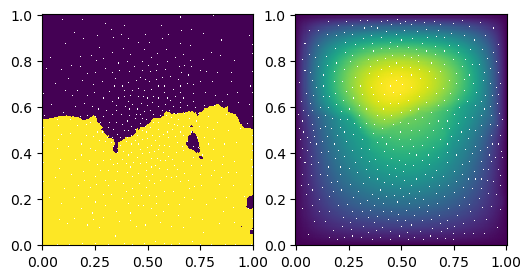

In [177]:
# visualize selection points
idx = 0
x_data = np.copy(x_train[idx, :])
x_data[x_idx[0:k_max]] = np.nan
y_data = np.copy(y_train[idx, :])
y_data[y_idx[0:k_max]] = np.nan

fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].pcolormesh(grid_x_ds, grid_y_ds, x_data.reshape(grid_x_ds.shape))
axs[1].pcolormesh(grid_x_ds, grid_y_ds, y_data.reshape(grid_x_ds.shape))


In [178]:
# test x_proj, we can use id to reconstruct proj matrix
x_proj_rec, residuals, rank, s = np.linalg.lstsq(x_train[:,x_idx[:k_max]], x_train)   
print("error ", np.linalg.norm(x_proj_rec - np.hstack([np.eye(k_max), x_proj])[:,np.argsort(x_idx)]))

/var/folders/ch/c01gr5_d0jbbqhb3qh06_vn40000gn/T/ipykernel_98003/1714158587.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_proj_rec, residuals, rank, s = np.linalg.lstsq(x_train[:,x_idx[:k_max]], x_train)


error  1.3231769595269619e-11


debug error =  7.235059432971872e-10
rel. reconstruction error =  0.10349612958494991


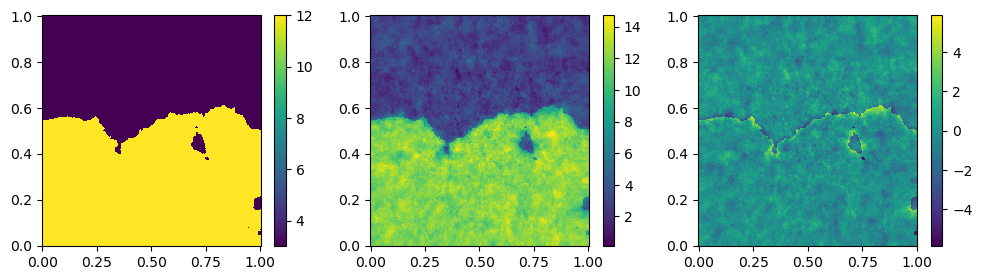

In [179]:
x_train_rec = np.dot(x_train[:,x_idx[:k_max]], x_proj_rec)
x_train_rec_org = np.dot(x_train[:,x_idx[:k_max]], np.hstack([np.eye(k_max), x_proj]))[:,np.argsort(x_idx)]
print("debug error = ", np.linalg.norm(x_train_rec_org - x_train_rec))

print("rel. reconstruction error = ", np.linalg.norm(x_train_rec - x_train)/np.linalg.norm(x_train))

fig, axs = plt.subplots(1, 3, figsize=(12, 3))

idx = 0
quad1 = axs[0].pcolormesh(grid_x_ds, grid_y_ds, x_train[idx, :].reshape(grid_x_ds.shape))
quad2 = axs[1].pcolormesh(grid_x_ds, grid_y_ds, x_train_rec[idx, :].reshape(grid_x_ds.shape))
quad3 = axs[2].pcolormesh(grid_x_ds, grid_y_ds, (x_train[idx, :] - x_train_rec[idx, :]).reshape(grid_x_ds.shape))

# Add a colorbar to each subplot
fig.colorbar(quad1, ax=axs[0])
fig.colorbar(quad2, ax=axs[1])
fig.colorbar(quad3, ax=axs[2])

# Column Selection

In [180]:
def column_selection(x_train, y_train, x_kmax, y_kmax):
    # x_train : Array[ndata, N]
    # y_train  : Array[ndata, N]
    # pick at most x_kmax points from x_train, and y_kmax from y_train
    x_idx, x_proj = sli.interp_decomp(x_train, x_kmax)
    y_idx, y_proj = sli.interp_decomp(y_train, y_kmax)
    
    union_idx = list(set(x_idx[0:x_kmax]).union(set(y_idx[0:y_kmax])))
    
    x_proj, residuals, rank, s = np.linalg.lstsq(x_train[:,union_idx], x_train)   
    y_proj, residuals, rank, s = np.linalg.lstsq(y_train[:,union_idx], y_train)   

    
    return union_idx, x_proj, y_proj

In [181]:
k_max = 256
x_kmax, y_kmax = k_max, k_max
xy_idx, x_proj, y_proj = column_selection(x_train, y_train, x_kmax, y_kmax)


/var/folders/ch/c01gr5_d0jbbqhb3qh06_vn40000gn/T/ipykernel_98003/184985125.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_proj, residuals, rank, s = np.linalg.lstsq(x_train[:,union_idx], x_train)
/var/folders/ch/c01gr5_d0jbbqhb3qh06_vn40000gn/T/ipykernel_98003/184985125.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y_proj, residuals, rank, s = np.linalg.lstsq(y_train[:,union_idx], y_train)


(511, 44521) (511, 44521)


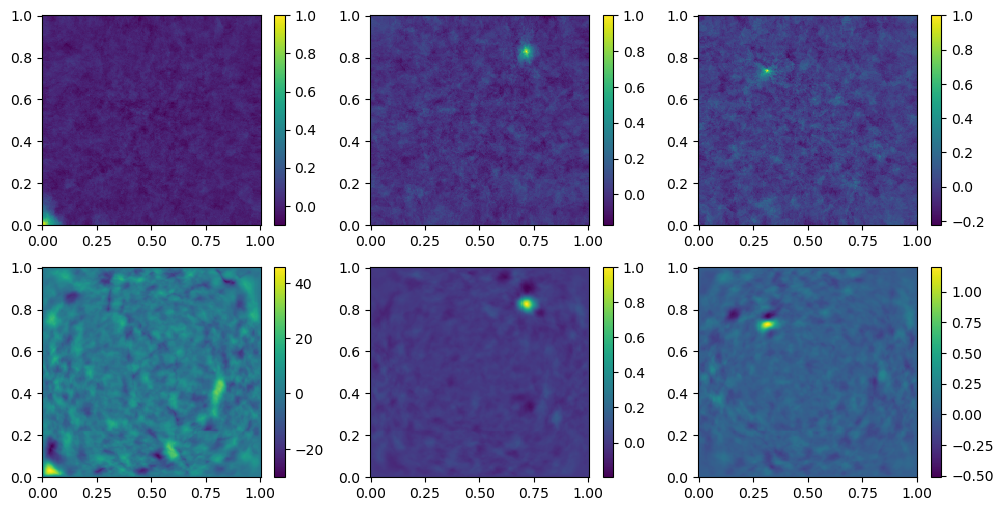

In [182]:
print(x_proj.shape, y_proj.shape)
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for i in range(3):
    quad = axs[0,i].pcolormesh(grid_x_ds, grid_y_ds, x_proj[i, :].reshape(grid_x_ds.shape))
    fig.colorbar(quad, ax=axs[0,i])
    quad = axs[1,i].pcolormesh(grid_x_ds, grid_y_ds, y_proj[i, :].reshape(grid_x_ds.shape))
    fig.colorbar(quad, ax=axs[1,i])




rel. x_train reconstruction error =  0.10615203823201304
rel. y_train reconstruction error =  0.003526342201965193


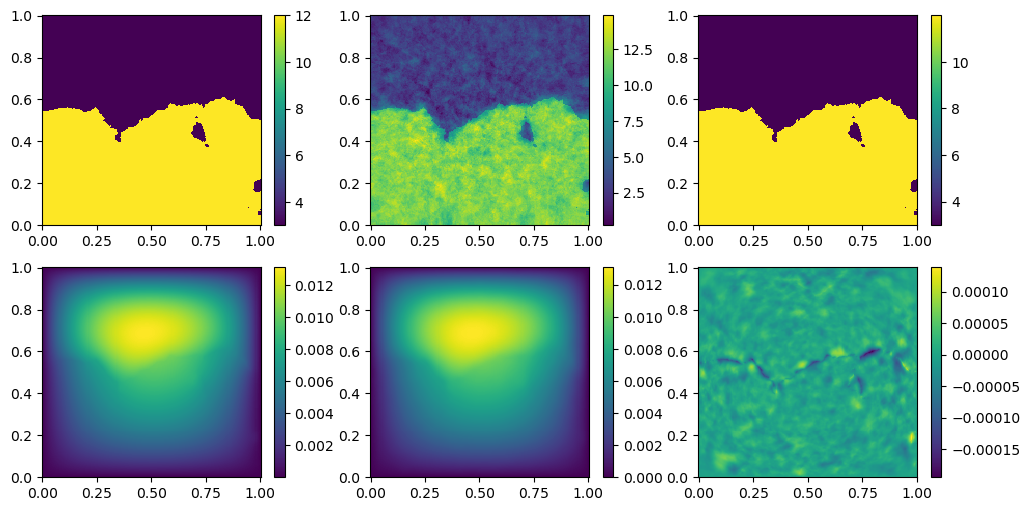

In [183]:
x_train_rec = np.dot(x_train[:, xy_idx], x_proj)
y_train_rec = np.dot(y_train[:, xy_idx], y_proj)

print("rel. x_train reconstruction error = ", np.average(np.linalg.norm(x_train_rec - x_train, axis=1)/np.linalg.norm(x_train, axis=1)))
print("rel. y_train reconstruction error = ", np.average(np.linalg.norm(y_train_rec - y_train, axis=1)/np.linalg.norm(y_train, axis=1)))

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

idx = 0
quad = axs[0,0].pcolormesh(grid_x_ds, grid_y_ds, x_train[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,0])
quad = axs[0,1].pcolormesh(grid_x_ds, grid_y_ds, x_train_rec[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,1])
quad = axs[0,2].pcolormesh(grid_x_ds, grid_y_ds, (x_train[idx, :] - y_train_rec[idx, :]).reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,2])
quad = axs[1,0].pcolormesh(grid_x_ds, grid_y_ds, y_train[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,0])
quad = axs[1,1].pcolormesh(grid_x_ds, grid_y_ds, y_train_rec[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,1])
quad = axs[1,2].pcolormesh(grid_x_ds, grid_y_ds, (y_train[idx, :] - y_train_rec[idx, :]).reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,2])



rel. x_test reconstruction error =  0.22292780945405608
rel. y_test reconstruction error =  0.007478763591600403


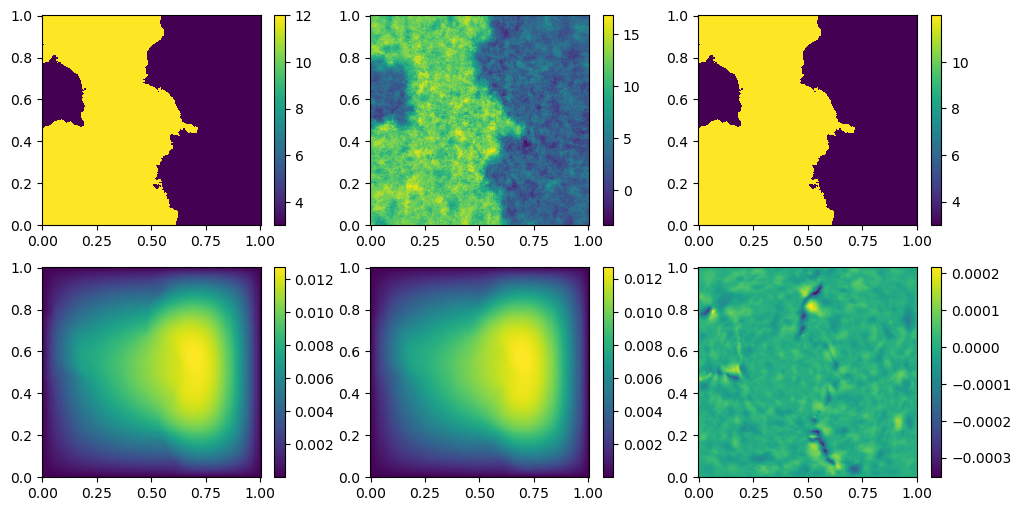

In [184]:
x_test_rec = np.dot(x_test[:, xy_idx], x_proj)
y_test_rec = np.dot(y_test[:, xy_idx], y_proj)

print("rel. x_test reconstruction error = ", np.average(np.linalg.norm(x_test_rec - x_test, axis=1)/np.linalg.norm(x_test, axis=1)))
print("rel. y_test reconstruction error = ", np.average(np.linalg.norm(y_test_rec - y_test, axis=1)/np.linalg.norm(y_test, axis=1)))

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

idx = 0
quad = axs[0,0].pcolormesh(grid_x_ds, grid_y_ds, x_test[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,0])
quad = axs[0,1].pcolormesh(grid_x_ds, grid_y_ds, x_test_rec[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,1])
quad = axs[0,2].pcolormesh(grid_x_ds, grid_y_ds, (x_test[idx, :] - y_test_rec[idx, :]).reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,2])
quad = axs[1,0].pcolormesh(grid_x_ds, grid_y_ds, y_test[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,0])
quad = axs[1,1].pcolormesh(grid_x_ds, grid_y_ds, y_test_rec[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,1])
quad = axs[1,2].pcolormesh(grid_x_ds, grid_y_ds, (y_test[idx, :] - y_test_rec[idx, :]).reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,2])

# Column Selection with PCA Bases

In [185]:
def column_selection_pca(x_train, y_train, x_kmax, y_kmax, x_pcamax, y_pcamax):
    # x_train : Array[ndata, N]
    # y_train  : Array[ndata, N]
    # pick at most x_kmax points from x_train, and y_kmax from y_train
    x_idx, x_proj = sli.interp_decomp(x_train, x_kmax)
    y_idx, y_proj = sli.interp_decomp(y_train, y_kmax)
    
    union_idx = list(set(x_idx[0:x_kmax]).union(set(y_idx[0:y_kmax])))
    
    U, S, VT = np.linalg.svd(x_train, full_matrices=False)
    x_pca =  VT[0:x_pcamax,:]
    print("x:truncation error: ", np.average(np.linalg.norm(x_train - x_train.dot(x_pca.T).dot(x_pca), axis=1)/np.linalg.norm(x_train, axis=1)))
    x_K,res,_,_ = np.linalg.lstsq(x_train[:,union_idx], x_train.dot(x_pca.T))  
    
    U, S, VT = np.linalg.svd(y_train, full_matrices=False)
    y_pca =  VT[0:y_pcamax,:]
    print("y:truncation error: ", np.average(np.linalg.norm(y_train - y_train.dot(y_pca.T).dot(y_pca), axis=1)/np.linalg.norm(y_train, axis=1)))
    
    y_K,_,_,_ = np.linalg.lstsq(y_train[:,union_idx], y_train.dot(y_pca.T))
    
    return union_idx, x_K.dot(x_pca) , y_K.dot(y_pca)

In [186]:
k_max = 256
x_kmax, y_kmax = k_max, k_max
pca_max = 256
x_pcamax, y_pcamax = pca_max, pca_max
xy_idx, x_proj, y_proj = column_selection_pca(x_train, y_train, x_kmax, y_kmax, x_pcamax, y_pcamax)


x:truncation error:  0.1146532366529439


/var/folders/ch/c01gr5_d0jbbqhb3qh06_vn40000gn/T/ipykernel_98003/111952723.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_K,res,_,_ = np.linalg.lstsq(x_train[:,union_idx], x_train.dot(x_pca.T))


y:truncation error:  0.0041085145400875135


/var/folders/ch/c01gr5_d0jbbqhb3qh06_vn40000gn/T/ipykernel_98003/111952723.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y_K,_,_,_ = np.linalg.lstsq(y_train[:,union_idx], y_train.dot(y_pca.T))


(512, 44521) (512, 44521)


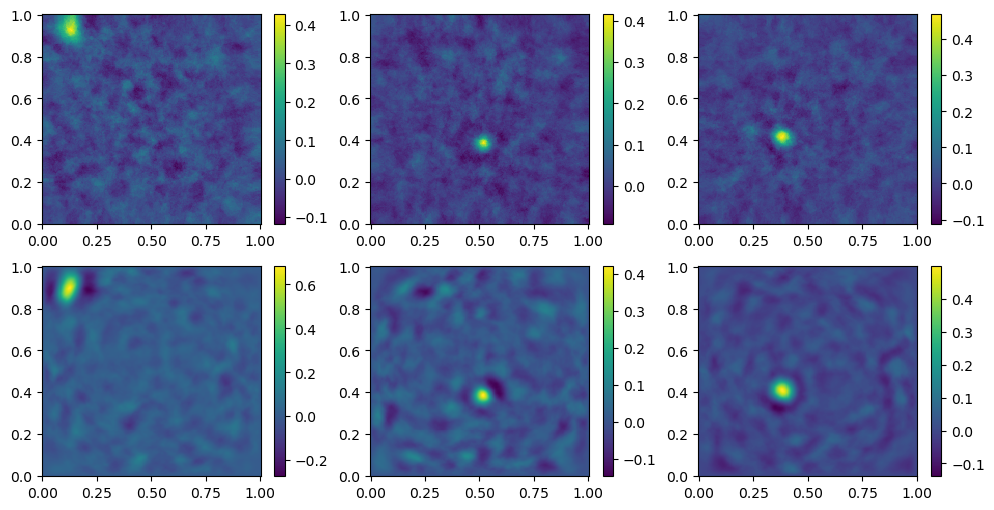

In [187]:
print(x_proj.shape, y_proj.shape)
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for i in range(3):
    quad = axs[0,i].pcolormesh(grid_x_ds, grid_y_ds, x_proj[i, :].reshape(grid_x_ds.shape))
    fig.colorbar(quad, ax=axs[0,i])
    quad = axs[1,i].pcolormesh(grid_x_ds, grid_y_ds, y_proj[i, :].reshape(grid_x_ds.shape))
    fig.colorbar(quad, ax=axs[1,i])




rel. x_train reconstruction error =  0.13200812425771113
rel. y_train reconstruction error =  0.004738053016157249


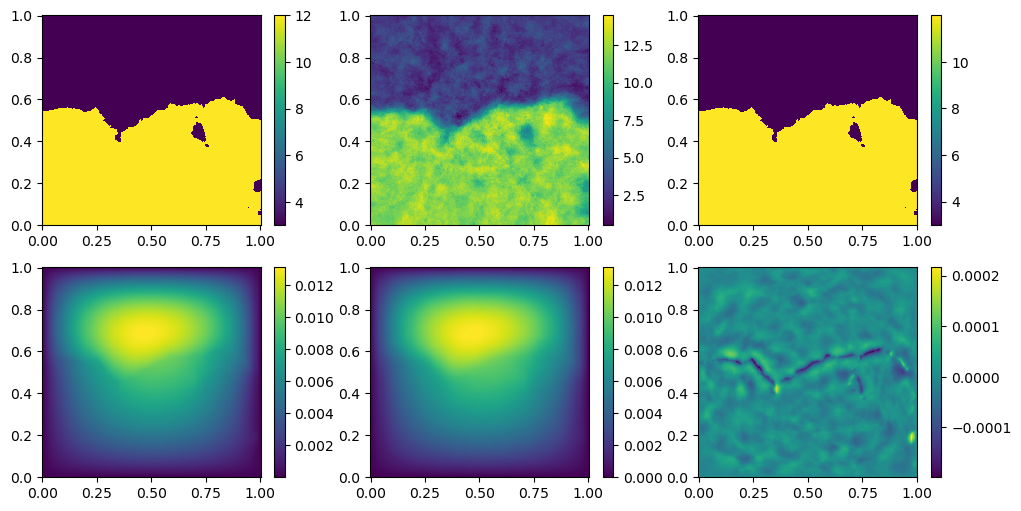

In [188]:
x_train_rec = np.dot(x_train[:, xy_idx], x_proj)
y_train_rec = np.dot(y_train[:, xy_idx], y_proj)

print("rel. x_train reconstruction error = ", np.average(np.linalg.norm(x_train_rec - x_train, axis=1)/np.linalg.norm(x_train, axis=1)))
print("rel. y_train reconstruction error = ", np.average(np.linalg.norm(y_train_rec - y_train, axis=1)/np.linalg.norm(y_train, axis=1)))

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

idx = 0
quad = axs[0,0].pcolormesh(grid_x_ds, grid_y_ds, x_train[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,0])
quad = axs[0,1].pcolormesh(grid_x_ds, grid_y_ds, x_train_rec[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,1])
quad = axs[0,2].pcolormesh(grid_x_ds, grid_y_ds, (x_train[idx, :] - y_train_rec[idx, :]).reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,2])
quad = axs[1,0].pcolormesh(grid_x_ds, grid_y_ds, y_train[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,0])
quad = axs[1,1].pcolormesh(grid_x_ds, grid_y_ds, y_train_rec[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,1])
quad = axs[1,2].pcolormesh(grid_x_ds, grid_y_ds, (y_train[idx, :] - y_train_rec[idx, :]).reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,2])



rel. x_test reconstruction error =  0.20299562595381626
rel. y_test reconstruction error =  0.007622127619456491


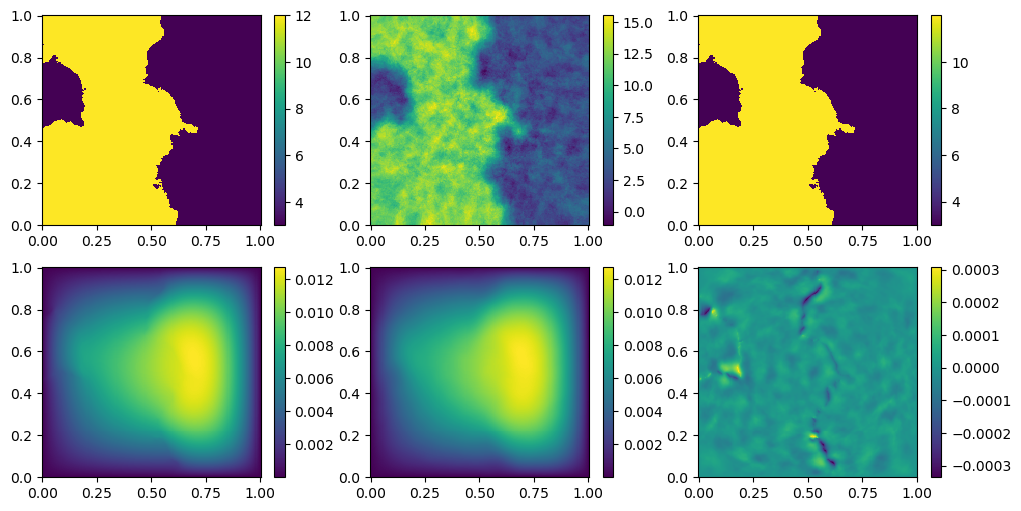

In [189]:
x_test_rec = np.dot(x_test[:, xy_idx], x_proj)
y_test_rec = np.dot(y_test[:, xy_idx], y_proj)

print("rel. x_test reconstruction error = ", np.average(np.linalg.norm(x_test_rec - x_test, axis=1)/np.linalg.norm(x_test, axis=1)))
print("rel. y_test reconstruction error = ", np.average(np.linalg.norm(y_test_rec - y_test, axis=1)/np.linalg.norm(y_test, axis=1)))

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

idx = 0
quad = axs[0,0].pcolormesh(grid_x_ds, grid_y_ds, x_test[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,0])
quad = axs[0,1].pcolormesh(grid_x_ds, grid_y_ds, x_test_rec[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,1])
quad = axs[0,2].pcolormesh(grid_x_ds, grid_y_ds, (x_test[idx, :] - y_test_rec[idx, :]).reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,2])
quad = axs[1,0].pcolormesh(grid_x_ds, grid_y_ds, y_test[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,0])
quad = axs[1,1].pcolormesh(grid_x_ds, grid_y_ds, y_test_rec[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,1])
quad = axs[1,2].pcolormesh(grid_x_ds, grid_y_ds, (y_test[idx, :] - y_test_rec[idx, :]).reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,2])

In [190]:
np.linalg.norm(y_test_rec - y_test, axis=1).shape

(500,)

# Kernel regression

In [191]:
def column_selection(x_train, y_train, x_kmax, y_kmax):
    # x_train : Array[ndata, N]
    # y_train  : Array[ndata, N]
    # pick at most x_kmax points from x_train, and y_kmax from y_train
    x_idx, x_proj = sli.interp_decomp(x_train, x_kmax)
    y_idx, y_proj = sli.interp_decomp(y_train, y_kmax)
    
    union_idx = list(set(x_idx[0:x_kmax]).union(set(y_idx[0:y_kmax])))
    
    x_proj, residuals, rank, s = np.linalg.lstsq(x_train[:,union_idx], x_train)   
    y_proj, residuals, rank, s = np.linalg.lstsq(y_train[:,union_idx], y_train)   

    
    return union_idx, x_proj, y_proj

In [193]:
k_max = 256
x_kmax, y_kmax = k_max, k_max
xy_idx, x_proj, y_proj = column_selection(x_train, y_train, x_kmax, y_kmax)


grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]


/var/folders/ch/c01gr5_d0jbbqhb3qh06_vn40000gn/T/ipykernel_98003/184985125.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_proj, residuals, rank, s = np.linalg.lstsq(x_train[:,union_idx], x_train)
/var/folders/ch/c01gr5_d0jbbqhb3qh06_vn40000gn/T/ipykernel_98003/184985125.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y_proj, residuals, rank, s = np.linalg.lstsq(y_train[:,union_idx], y_train)


In [194]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
X = np.column_stack((grid_x_ds.reshape(-1)[xy_idx],grid_y_ds.reshape(-1)[xy_idx])) 
X_new = np.column_stack((grid_x_ds.reshape(-1),grid_y_ds.reshape(-1))) 

# Define a Gaussian Process model with a kernel
kernel = RBF(0.1, (1e-4, 1e1))  # RBF kernel
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-8, n_restarts_optimizer=10)
# Fit the model to the data


In [195]:
idx = 100
y = x_test[idx, xy_idx]
gp.fit(X, y)
x_test_pred, x_test_sigma = gp.predict(X_new, return_std=True)
y = y_test[idx, xy_idx]
gp.fit(X, y)
y_test_pred, y_test_sigma = gp.predict(X_new, return_std=True)





rel. x_test reconstruction error =  0.23606535401011688
rel. y_test reconstruction error =  0.02108451005456434


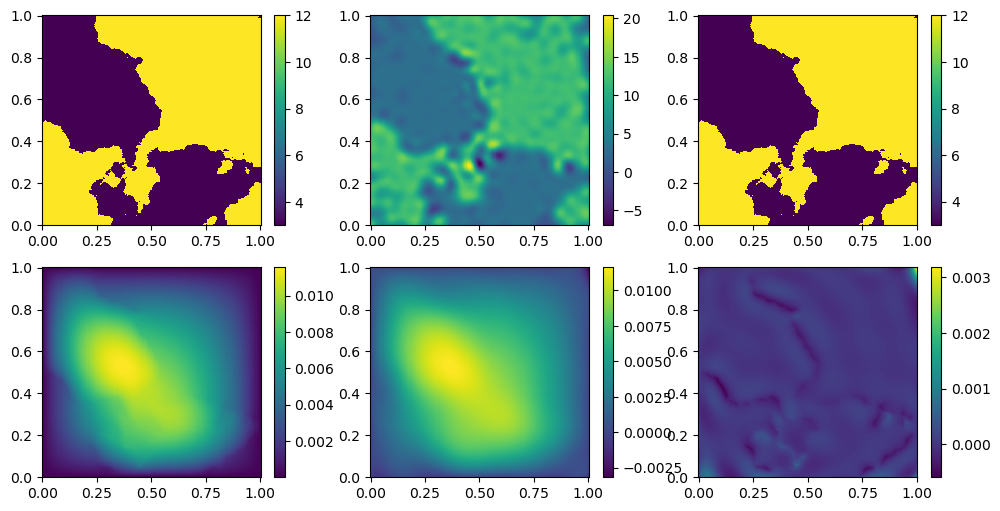

In [196]:
# x_test_rec = np.dot(x_test[:, xy_idx], x_proj)
# y_test_rec = np.dot(y_test[:, xy_idx], y_proj)

print("rel. x_test reconstruction error = ", np.average(np.linalg.norm(x_test_pred - x_test[idx, :])/np.linalg.norm(x_test[idx, :])))
print("rel. y_test reconstruction error = ", np.average(np.linalg.norm(y_test_pred - y_test[idx, :])/np.linalg.norm(y_test[idx, :])))

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

quad = axs[0,0].pcolormesh(grid_x_ds, grid_y_ds, x_test[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,0])
quad = axs[0,1].pcolormesh(grid_x_ds, grid_y_ds, x_test_pred.reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,1])
quad = axs[0,2].pcolormesh(grid_x_ds, grid_y_ds, (x_test[idx, :] - y_test_pred).reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,2])
quad = axs[1,0].pcolormesh(grid_x_ds, grid_y_ds, y_test[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,0])
quad = axs[1,1].pcolormesh(grid_x_ds, grid_y_ds, y_test_pred.reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,1])
quad = axs[1,2].pcolormesh(grid_x_ds, grid_y_ds, (y_test[idx, :] - y_test_pred).reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[1,2])

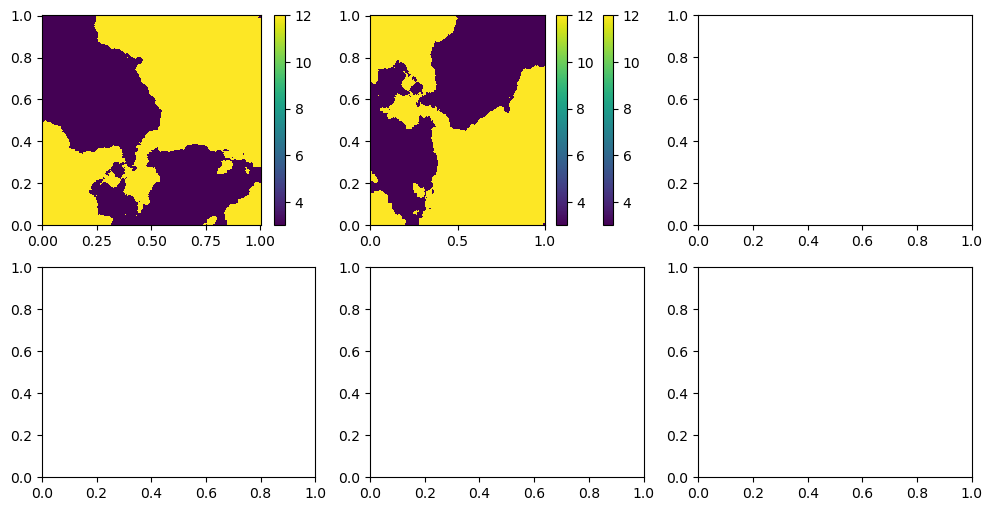

In [197]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

quad = axs[0,0].pcolormesh(grid_x_ds, grid_y_ds, x_test[idx, :].reshape(grid_x_ds.shape))
fig.colorbar(quad, ax=axs[0,0])
quad = axs[0,1].pcolormesh(grid_x_ds, grid_y_ds, np.rot90(x_test[idx, :].reshape(grid_x_ds.shape)))
fig.colorbar(quad, ax=axs[0,1])
quad = axs[0,1].pcolormesh(grid_x_ds, grid_y_ds, np.rot90(x_test[idx, :].reshape(grid_x_ds.shape)))
fig.colorbar(quad, ax=axs[0,1])

In [169]:
a = np.rot90(np.ones((2,3,4)), axes=(1,2))